# Memecoin index strategy 

- ETH variant
- Equally weighted

# Set up

Set up Trading Strategy data client.


In [11]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [12]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "eth-meme-01"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = {"Meme"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 10  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 99  # How many assets our basket can hold once
    allocation = 0.92  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    min_volatility_threshold = 0.02  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS
    
    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 50_000   # USD
    min_liquidity = 200_000  # USD
    min_tvl = 25_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2025, 1, 3)
    initial_cash = 10_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [13]:
import warnings

from eth_defi.token import USDC_NATIVE_TOKEN

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.token_extra_data import filter_scams




#: Assets used in routing and buy-and-hold benchmark values for our strategy, but not traded by this strategy.
SUPPORTING_PAIRS = [
    (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
    (ChainId.ethereum, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
]


# Will be converted to cbBTC/ETH->USDC
VOL_PAIR = (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030)


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=USDC_NATIVE_TOKEN[chain_id.value],  # USDC on Base 
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    print("Universe is (including benchmark pairs):")
    for idx, pair in enumerate(strategy_universe.iterate_pairs()):
        benchmark = pair.other_data.get("benchmark")
        print(f"   {idx + 1}. pair #{pair.internal_id}: {pair.base.token_symbol} - {pair.quote.token_symbol} ({pair.exchange_name}), {'benchmark/routed token' if benchmark else 'traded token'}")

    return strategy_universe


# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 2460 tokens>
Total 120 pairs to trade on ethereum for categories {'Meme'}
After scam filter we have 111 pairs
Scammy pair SHIRO - WETH, risk score 0.0, pool 0xd293d05e83035a757d510e2a5ebfe705c4f05b1f, token 0xb0ac2b5a73da0e67a8e5489ba922b3f8d582e058
Scammy pair TRUMP - WETH, risk score 0.0, pool 0x56bc8f3293f53825c9fbd6ddfe0cafefa82820d0, token 0x6aa56e1d98b3805921c170eb4b3fe7d4fda6d89b
Scammy pair BabyDoge - WETH, risk score 0.0, pool 0x9f2ebe69a86c079f3d4c3b94a11932b676b72f74, token 0xac57de9c1a09fec648e93eb98875b212db0d460b
Scammy pair GSWIFT - WETH, risk score nan, pool 0x715a3ceac0d039d674f50b07804592e87e8c6d77, token 0x580e933d90091b9ce380740e3a4a39c67eb85b4c
Scammy pair VOLT - WETH, risk score 25.0, pool 0x96aa22baedc5a605357e0b9ae20ab6b10a472e03, token 0x7f792db54b0e580cdc755178443f0430cf799aca
Scammy pair Puff - WETH, risk score 25.0, pool 0x0275885d271c9e5ae7d4aa15ae6c1bcb7e5ae2b8, token 0x31b6100f5f4466e6daeb1edb2f2ce6e548cf8938
S

Loading TVL/liquidity data for 111 pairs:   0%|          | 0/111 [00:00<?, ?it/s]

Universe is (including benchmark pairs):
   1. pair #4999091: KEKIUS - WETH (uniswap-v2), traded token
   2. pair #3271833: SPX - WETH (uniswap-v2), traded token
   3. pair #4974667: PEPU - WETH (uniswap-v3), traded token
   4. pair #3010484: PEPE - WETH (uniswap-v2), traded token
   5. pair #1: WETH - USDC (uniswap-v2), benchmark/routed token
   6. pair #4306260: DOGE - WETH (uniswap-v2), traded token
   7. pair #3226046: Mog - WETH (uniswap-v2), traded token
   8. pair #4964467: CULT - WETH (uniswap-v3), traded token
   9. pair #4984458: MYSTERY - WETH (uniswap-v2), traded token
   10. pair #4372640: MOODENG - WETH (uniswap-v2), traded token
   11. pair #3822814: Neiro - WETH (uniswap-v2), traded token
   12. pair #4611117: PATRIOT - WETH (uniswap-v2), traded token
   13. pair #2715717: OMIKAMI - WETH (uniswap-v2), traded token
   14. pair #3576318: APU - WETH (uniswap-v2), traded token
   15. pair #3573307: ANDY - WETH (uniswap-v2), traded token
   16. pair #3073784: BITCOIN - WETH 

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [14]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 111 assets
Category trading pairs 109
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [15]:
import pandas as pd
import numpy as np
from IPython.display import HTML

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry


indicators = IndicatorRegistry()


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std


@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


# Display indicators diagnostics table
indicators_debug_df = indicators.get_diagnostics()
print(f"We have {len(indicators_debug_df)} indicators:")
def replace_comma_with_newline(text):
    # print(text)
    if isinstance(text, str):        
        return text.replace(',', '<br>')
    return text
indicators_debug_df = indicators_debug_df.map(replace_comma_with_newline)
display(HTML(indicators_debug_df.to_html(escape=False)))


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
)

We have 19 indicators:


Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mean_returns, roll…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_111_2022-08-15-2025-01-03_ff


# Available pairs

- Number of pairs available to trade every month



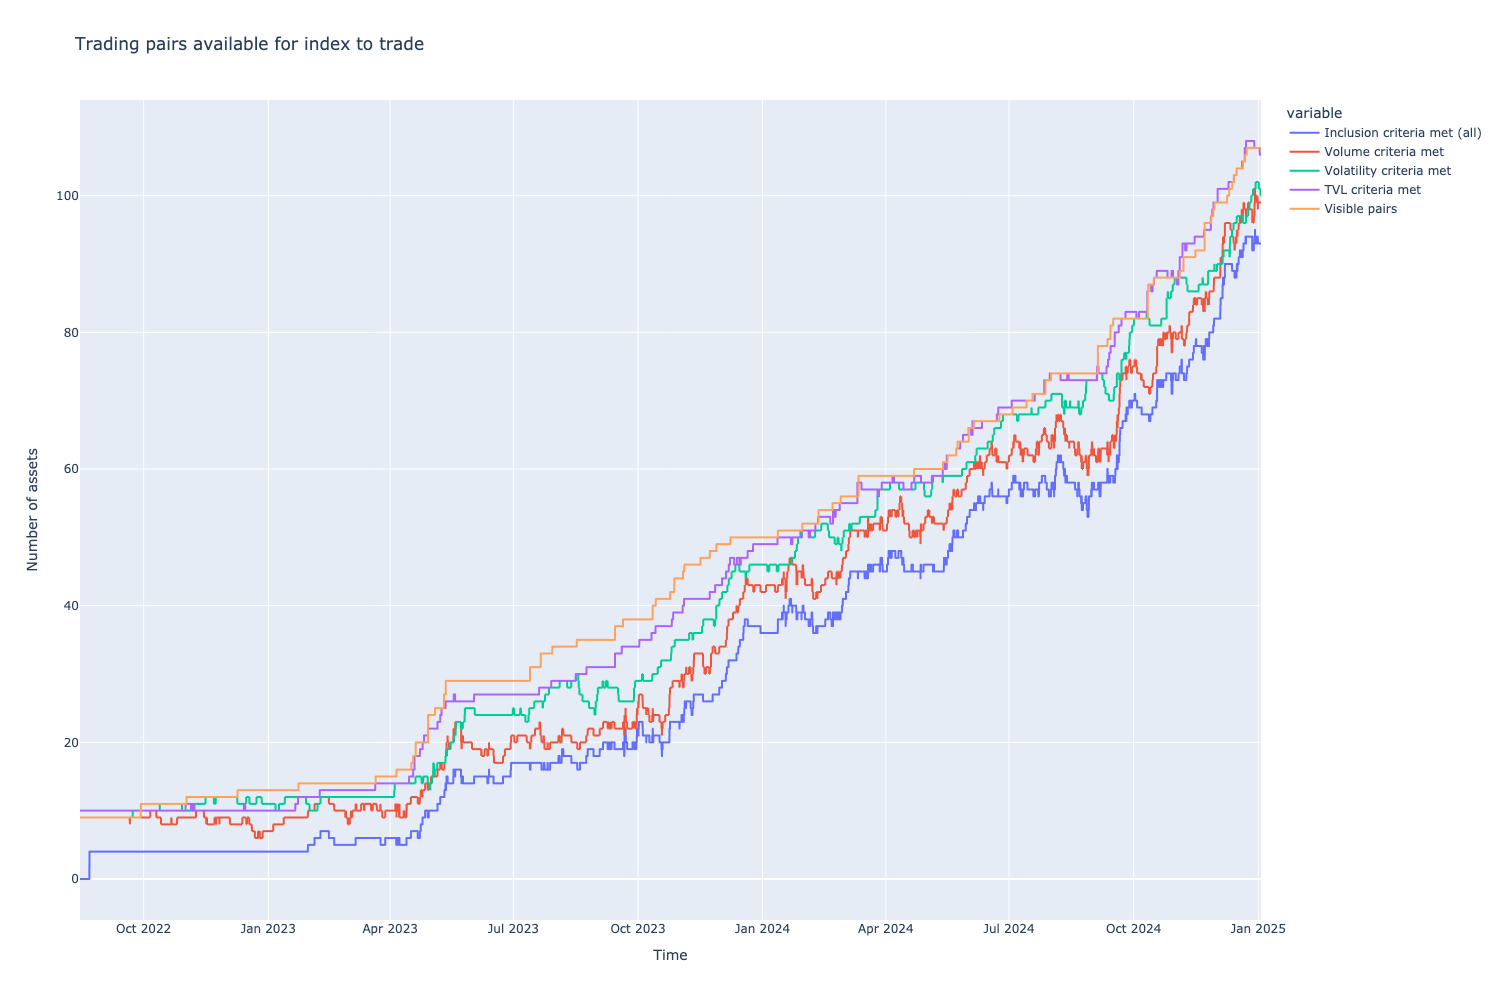

Inclusion criteria met (all)  Volume criteria met  \
2025-01-02 20:00:00                            93                 99.0   
2025-01-02 21:00:00                            93                 99.0   
2025-01-02 22:00:00                            93                 99.0   
2025-01-02 23:00:00                            93                 99.0   
2025-01-03 00:00:00                            93                 99.0   

                     Volatility criteria met  TVL criteria met  Visible pairs  
2025-01-02 20:00:00                    100.0               106            107  
2025-01-02 21:00:00                    100.0               106            107  
2025-01-02 22:00:00                    100.0               106            107  
2025-01-02 23:00:00                    100.0               106            107  
2025-01-03 00:00:00                    100.0               106            107

In [16]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [17]:
series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

df["Ticker"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).get_ticker())
df["DEX"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).exchange_name)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
        pair_id,
        timestamp,
        tolerance=pd.Timedelta(days=2),
    )
    return tvl

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 103 trading pairs, when they meet all inclusion criteria:


Included at           Ticker         DEX  TVL at inclusion  \
7717    2022-08-21 23:00:00       LEASH-WETH  uniswap-v2        288,670.11   
37316   2022-08-21 23:00:00        ELON-WETH  uniswap-v2     12,066,279.63   
68900   2022-08-21 23:00:00       FLOKI-WETH  uniswap-v2      2,749,733.48   
2697640 2022-08-21 23:00:00        SHIB-WETH  uniswap-v3      1,213,847.38   
2894712 2023-01-30 07:00:00     OPTIMUS-WETH  uniswap-v2         61,630.47   
2833961 2023-02-04 03:00:00      KIBSHI-WETH  uniswap-v2         42,199.13   
2785201 2023-02-08 13:00:00       LMEOW-WETH  uniswap-v2         37,794.81   
2711945 2023-03-28 09:00:00      PEOPLE-WETH  uniswap-v3        132,815.75   
3010484 2023-04-23 15:00:00        PEPE-WETH  uniswap-v2      3,388,108.76   
3015124 2023-04-24 23:00:00       WOJAK-WETH  uniswap-v2        689,871.53   
3018875 2023-04-26 21:00:00         BOB-WETH  uniswap-v2        375,012.96   
3038307 2023-05-06 00:00:00    pepecoin-WETH  uniswap-v2      1,017,782.22   
3033402 2023-05-08 01:00:00       $MONG-WETH  uniswap-v2      2,227,434.06   
3047249 2023-05-11 02:00:00       TURBO-WETH  uniswap-v3         29,609.79   
3031971 2023-05-12 08:00:00       JESUS-WETH  uniswap-v2        123,823.04   
3026347 2023-05-12 15:00:00        OSAK-WETH  uniswap-v2        719,102.48   
3061151 2023-05-17 16:00:00       LADYS-WETH  uniswap-v2      2,032,345.29   
3073705 2023-05-19 03:00:00        BOBO-WETH  uniswap-v2        137,460.59   
3073784 2023-06-02 00:00:00     BITCOIN-WETH  uniswap-v3         47,657.85   
3054571 2023-06-29 00:00:00         BAD-WETH  uniswap-v2        978,346.57   
3226046 2023-07-28 04:00:00         Mog-WETH  uniswap-v2        578,237.56   
3242770 2023-08-05 16:00:00         NPC-WETH  uniswap-v2         95,959.61   
3271833 2023-08-23 19:00:00         SPX-WETH  uniswap-v2        211,915.12   
33231   2023-09-02 18:00:00        HOGE-WETH  uniswap-v2        240,218.31   
3311668 2023-09-21 00:00:00    шайлушай-WETH  uniswap-v2        261,582.32   
3308171 2023-09-21 20:00:00        PSPS-WETH  uniswap-v2         51,164.49   
3319606 2023-09-26 22:00:00         APX-WETH  uniswap-v2        267,130.50   
3347784 2023-10-18 19:00:00         JOE-WETH  uniswap-v2        342,708.41   
3361302 2023-10-31 18:00:00        BCAT-WETH  uniswap-v2        177,103.55   
3367917 2023-11-03 19:00:00       Kekec-WETH  uniswap-v2        237,122.38   
3376429 2023-11-10 06:00:00        MEME-WETH  uniswap-v3        149,476.72   
3377643 2023-11-11 04:00:00        GROK-WETH  uniswap-v2      1,029,047.13   
83008   2023-11-25 03:00:00       TSUKA-USDC  uniswap-v2      1,434,975.65   
3424238 2023-11-30 00:00:00          Q*-WETH  uniswap-v2        201,644.52   
3402904 2023-12-02 00:00:00        Bonk-WETH  uniswap-v3         44,112.78   
3430630 2023-12-04 21:00:00         ZYN-WETH  uniswap-v2        201,604.88   
3216759 2023-12-05 15:00:00       $WOLF-WETH  uniswap-v2        140,435.69   
3365484 2023-12-12 19:00:00         DOG-WETH  uniswap-v3      3,707,325.32   
3445245 2023-12-15 05:00:00        BYTE-WETH  uniswap-v2        367,269.63   
3000217 2023-12-18 00:00:00        KATA-WETH  uniswap-v3        116,982.30   
3484249 2024-01-12 07:00:00     PEPE2.0-WETH  uniswap-v2      1,044,686.25   
2713084 2024-01-15 07:00:00         SHI-WETH  uniswap-v3      1,979,795.58   
3017331 2024-01-20 02:00:00       TROLL-WETH  uniswap-v2      2,451,166.61   
3523948 2024-02-06 06:00:00        PORK-WETH  uniswap-v3     13,891,665.13   
3540193 2024-02-18 08:00:00     puppies-WETH  uniswap-v2        121,410.72   
3552847 2024-02-28 14:00:00       Kendu-WETH  uniswap-v2         84,011.00   
3350536 2024-03-05 17:00:00        NATI-WETH  uniswap-v2        661,226.47   
3576318 2024-03-18 19:00:00         APU-WETH  uniswap-v2        768,190.15   
3573307 2024-03-18 19:00:00        ANDY-WETH  uniswap-v2        113,318.16   
3574910 2024-03-28 00:00:00       HOPPY-WETH  uniswap-v2         48,879.62   
3634091 2024-04-28 20:00:00        WOL

In [18]:
# ts = pd.Timestamp("2024-02-14 02:00:00")
# series = indicator_data.get_indicator_data_pairs_combined("tvl")
# display(series.loc[(4572399, ts)])

# #display(series)
# mask = series >= Parameters.min_tvl
# # Turn to a series of lists
# mask_true_values_only = mask[mask == True]
# display(mask_true_values_only)
# series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())


# #display(mask.reset_index().groupby("timestamp"))
# #display(mask[(4572399, ts)])
# display(series[ts])
# display(series)


# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [19]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-05-06 00:00:00 - 2025-01-03 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [20]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        weight = 1

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_equal)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mean_returns, roll…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_111_2022-08-15-2025-01-03_ff


  0%|          | 0/52531200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 83139 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [21]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=["WETH", "KEYCAT", "ANDY"],
)

Strategy                  ETH  \
Start Period                        2023-05-06           2023-05-06   
End Period                          2025-01-02           2025-01-02   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                          100.0%               100.0%   
Cumulative Return                   16,921.58%               68.80%   
CAGR﹪                                  743.75%               24.28%   
Sharpe                                    3.64                 0.84   
Prob. Sharpe Ratio                      100.0%               86.28%   
Smart Sharpe                              3.59                 0.82   
Sortino                                   6.37                  1.3   
Smart Sortino                             6.29                 1.28   
Sortino/√2                                 4.5                 0.92   
Smart Sortino/√2                          4.44                  0.9   
Omega                                     1.69                  1.7   
Max Drawdown                           -42.63%              -44.99%   
Longest DD Days                             58                  296   
Volatility (ann.)                       98.08%               56.46%   
Calmar                                   17.45                 0.54   
Skew                                      0.33                 0.71   
Kurtosis                                  2.54                 5.31   
Expected Daily                           0.85%                0.09%   
Expected Monthly                        27.71%                2.52%   
Expected Yearly                         454.2%               19.07%   
Kelly Criterion                         22.36%               10.38%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -7.47%               -4.73%   
Expected Shortfall (cVaR)               -7.47%               -4.73%   
Max Consecutive Wins                        12                    8   
Max Consecutive Losses                       7                    6   
Gain/Pain Ratio                           0.69                 0.13   
Gain/Pain (1M)                            6.63                 1.24   
Payoff Ratio                              1.41                 1.19   
Profit Factor                             1.69                 1.13   
Common Sense Ratio                        2.49                 1.23   
CPC Index                                  1.3                 0.69   
Tail Ratio                                1.47                 1.08   
Outlier Win Ratio                         3.43                 5.61   
Outlier Loss Ratio                        3.42                  4.4   
MTD                                      5.95%                 1.6%   
3M                                      57.21%               29.59%   
6M                                     105.35%               -1.49%   
YTD                                      5.95%                 1.6%   
1Y                                     2094.4%               47.89%   
3Y (ann.)                              743.75%               24.28%   
5Y (ann.)                              743.75%               24.28%   
10Y (ann.)                             743.75%               24.28%   
All-time (ann.)                        743.75%               24.28%   
Best Day                                 25.5%               20.18%   
Worst Day                              -24.57%              -13.41%   
Best Month                             174.34%               47.77%   
Worst Month                            -44.65%              -22.85%   
Best Year                             2050.94%               44.96%   
Worst Year                               5.95%                 1.6%   
Avg. Drawdown                           -8.11%              -10.04%   
Avg. Drawdown Days                           8                   41   
Recovery Factor                          13.95                

# Equity curve

- Equity curve shows how your strategy accrues value over time

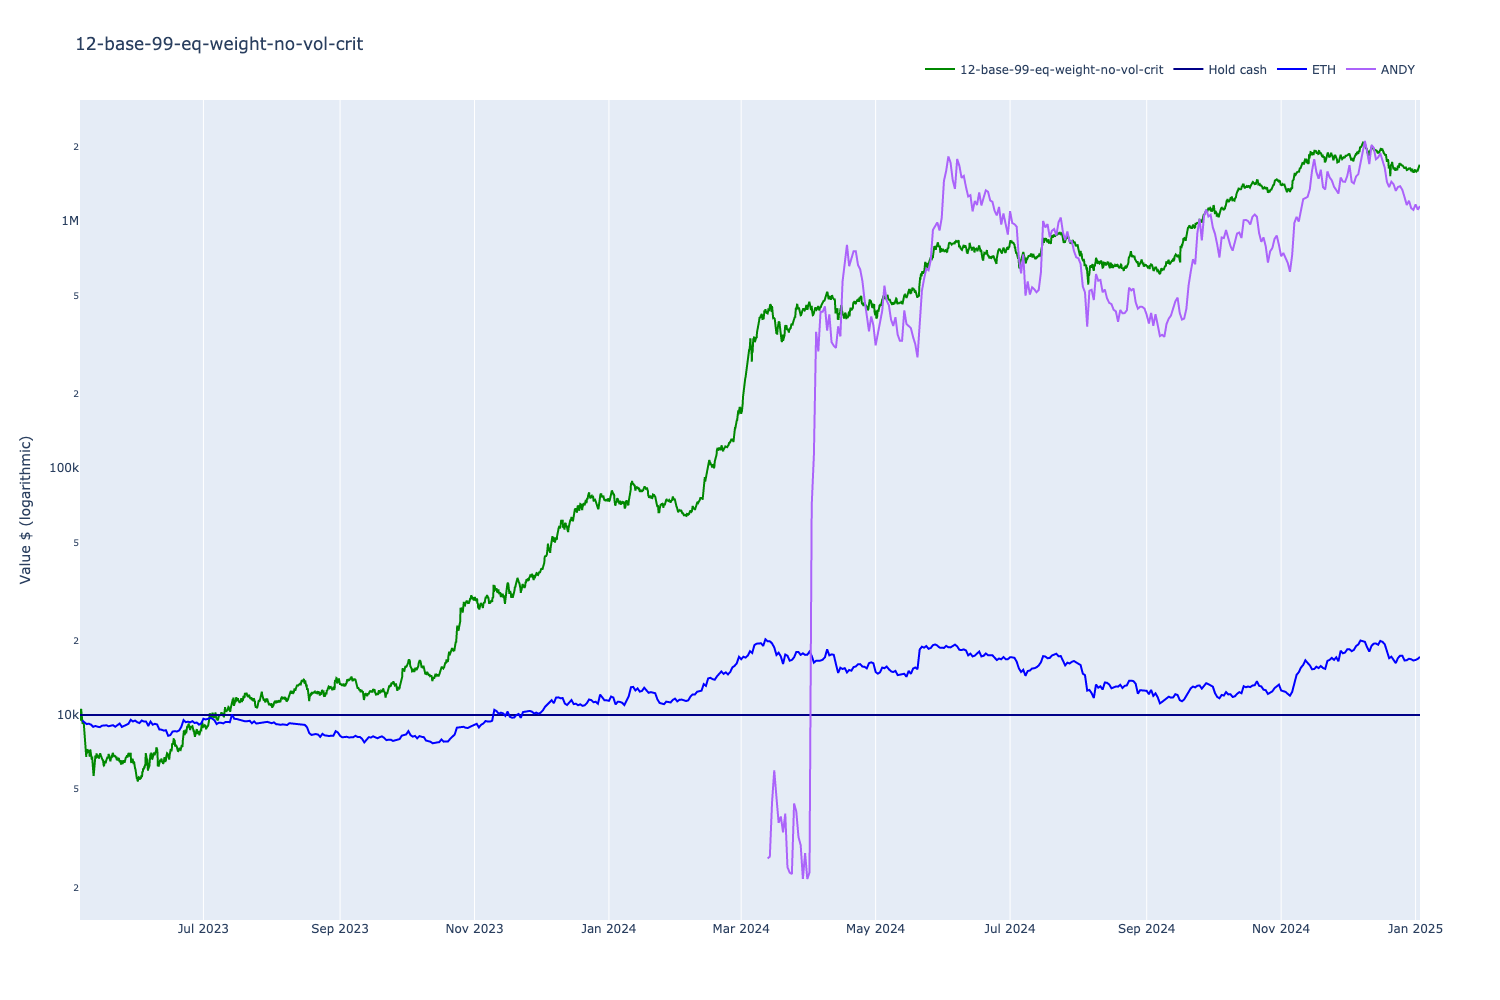

In [22]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "ANDY", "weirdo"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

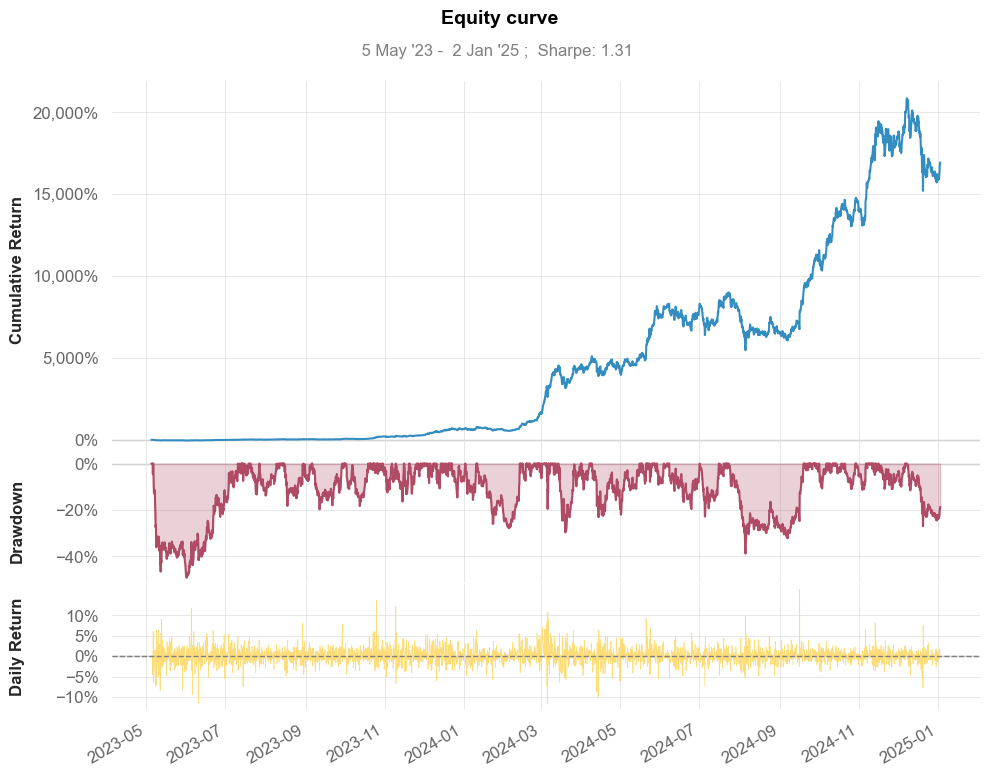

In [23]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

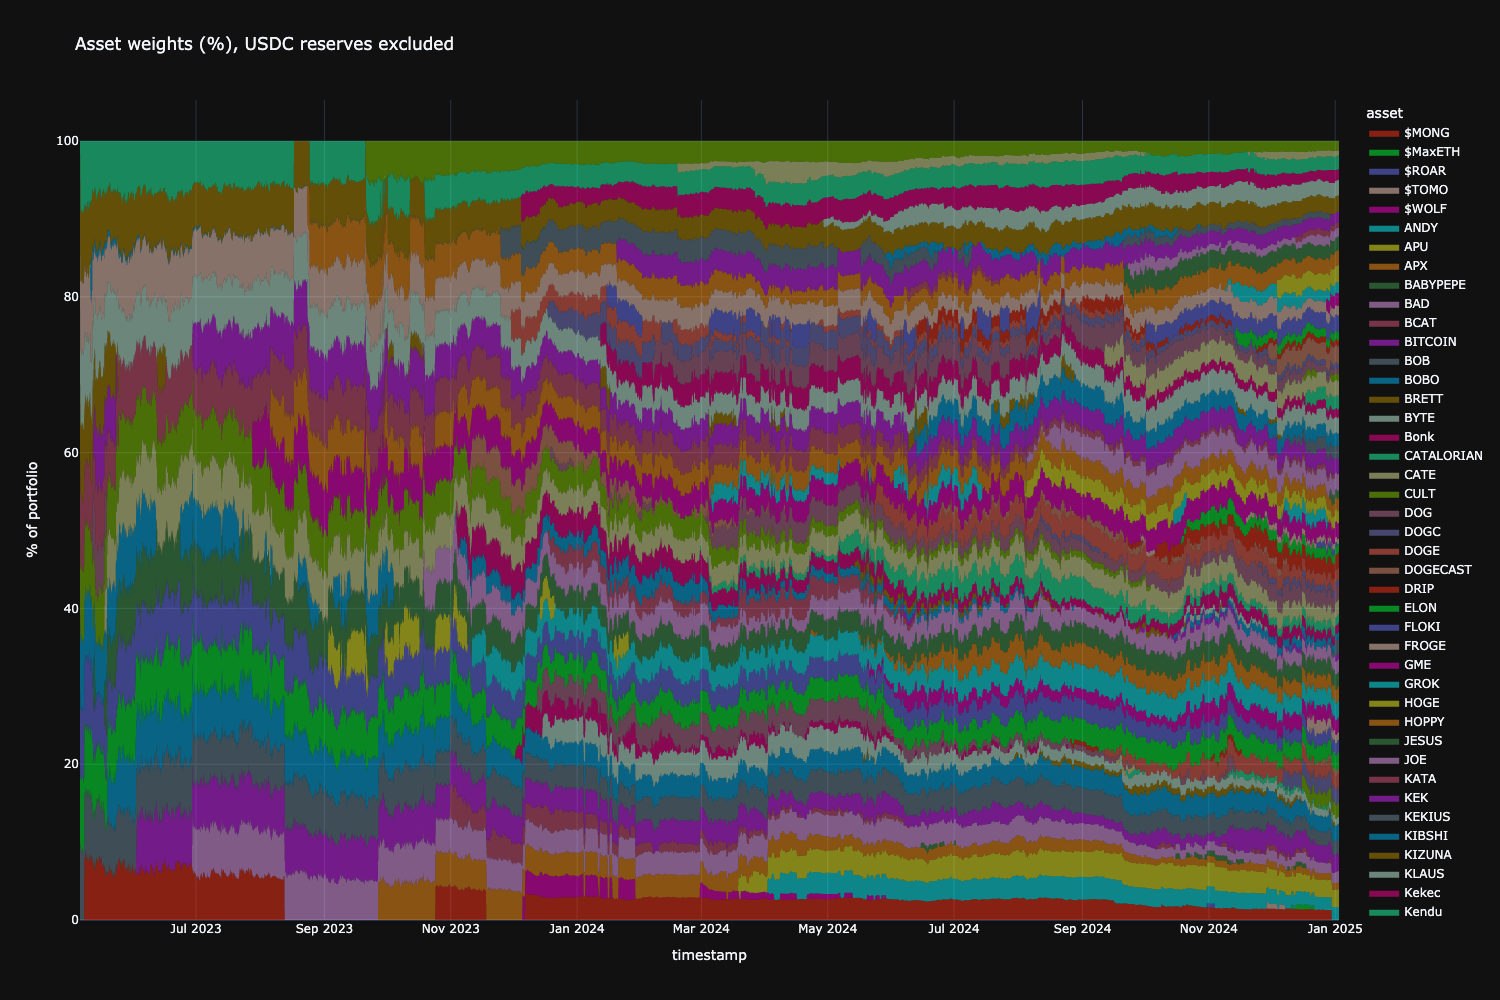

In [24]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

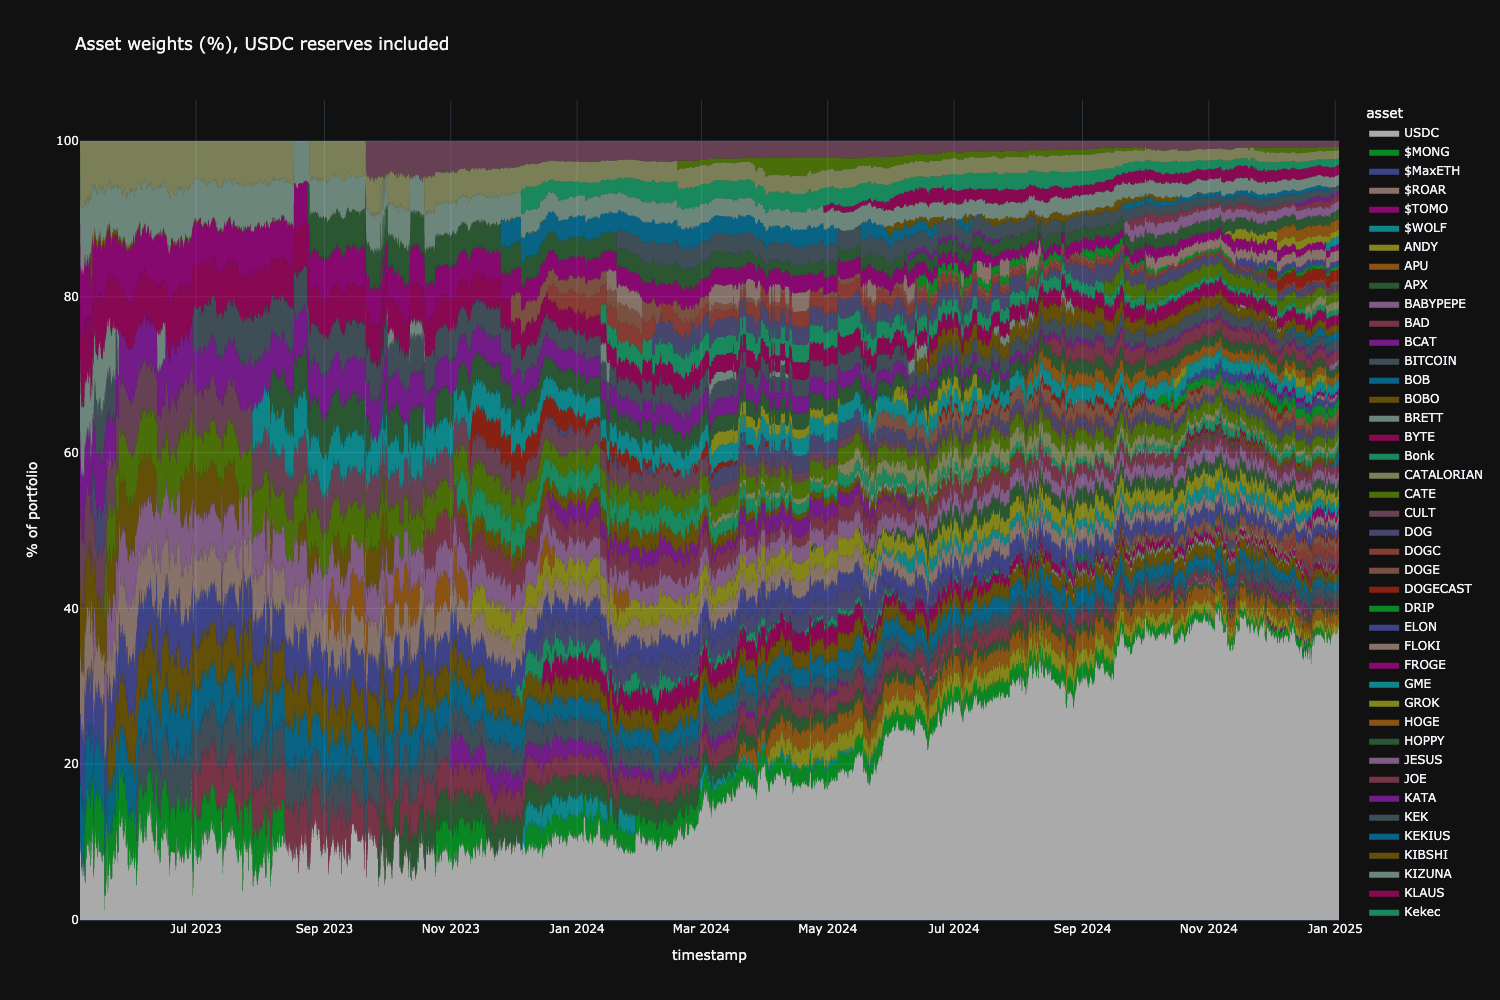

In [25]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

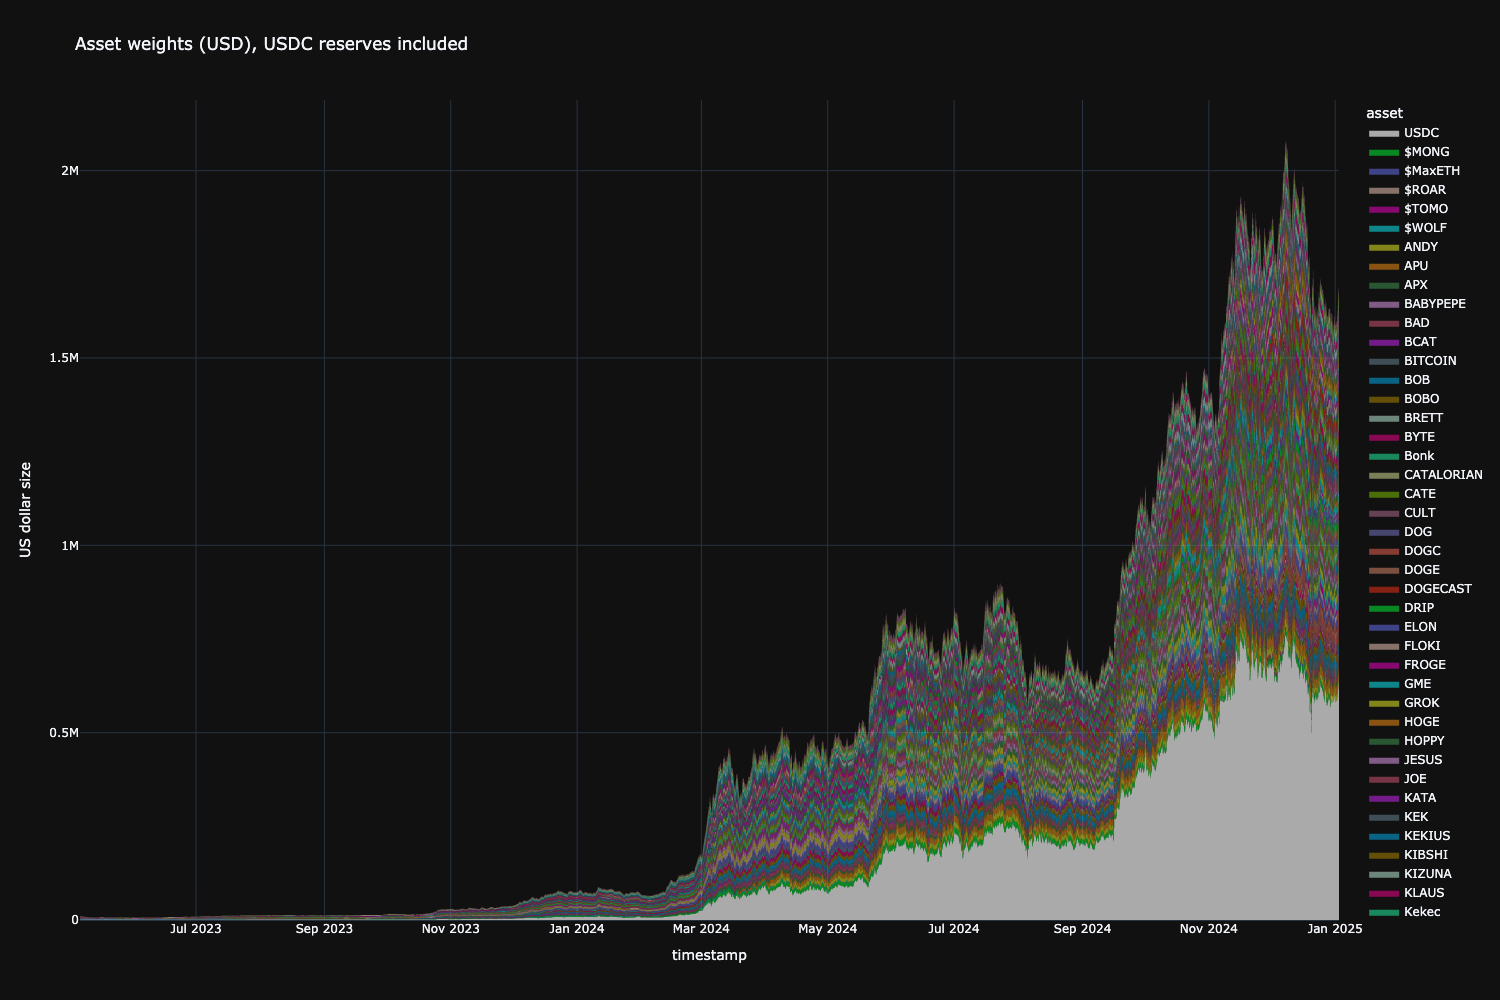

In [26]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [27]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At   Pair      Value Unit
Name                                                                      
Max position (excluding USDC)   2024-11-16 20:00:00    APU  34,746.24  USD
Min position (excluding USDC)   2023-10-18 04:00:00  TURBO       0.10  USD
Mean position (excluding USDC)                               8,863.63  USD
Max position (excluding USDC)   2023-05-06 00:00:00   ELON      10.01    %
Min position (excluding USDC)   2023-10-18 12:00:00  TURBO       0.00    %
Mean position (excluding USDC)                                   2.63    %
Max position (including USDC)   2024-11-06 20:00:00   USDC      40.57    %
Min position (including USDC)   2023-10-18 12:00:00  TURBO       0.00    %
Mean position (including USDC)                                   2.57    %

# Positions at the end

Some example positions at the end


In [28]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position ELON, value 21627.664082882024 USD
Position FLOKI, value 16900.545365346403 USD
Position SHIB, value 12783.877299206833 USD
Position WOJAK, value 22150.25434557924 USD
Position PEPE, value 21477.679466959977 USD
Position BOB, value 19208.513856375885 USD
Position LADYS, value 20530.40027976678 USD
Position JESUS, value 19033.87126965686 USD
Position BOBO, value 21070.33427514537 USD
Position BITCOIN, value 24112.323569151744 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [29]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [30]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                     
$MaxETH-WETH        1.0  22820.537888    5216.309325       5216.309325   
PHIL-WETH           1.0  21077.779155   21077.779155        143.556572   
PEPU-WETH           1.0  17737.826295   17737.826295      -1780.469486   
PEPE2.0-WETH        1.0  18352.633960   11358.663997         36.860043   
PEPE-WETH           1.0  21478.990951   21478.990951        219.236345   
PEOPLE-WETH         1.0  19477.437205    3879.163177       3879.163177   
PEIPEI-WETH         1.0  17737.826295   17737.826295        222.171604   
PATRIOT-WETH        1.0  17132.249815   17132.249815      -1167.435681   
OSAK-WETH           1.0  21228.279247   20256.577595       -190.982239   
OPTIMUS-WETH        1.0  19063.703519    5445.175537       5445.175537   
Neiro-WETH          1.0  22650.873897   22650.873897        433.955803   
NUMBER-WETH         1.0  22349.777928   10290.067481        700.483507   
NPC-WETH            1.0  16777.630488   16777.630488       -371.923348   
NEIRO-WETH          1.0  16777.630488   16777.630488        281.123025   
NASDAQ420-WETH      1.0  21630.189885    3400.536557       3400.536557   
Mog-WETH            1.0  21478.990951   21478.990951         57.628234   
Marvin-WETH         1.0  18427.837938    6357.336962       -167.364896   
MYSTERY-WETH        1.0  19645.160582    4837.185135       4837.185135   
MSTR-WETH           1.0  16725.151858   11844.639325       -498.664382   
MOODENG-WETH        1.0  20531.087917   20531.087917      -1166.771502   
PIKA-WETH           1.0  23296.649447    9176.055173         86.641159   
PORK-WETH           1.0  18885.628025    6826.338397         35.500804   
PSPS-WETH           1.0  19804.386124    6227.175232        -31.078323   
Q*-WETH             1.0  23659.291005    4735.714224       4735.714224   
puppies-WETH        1.0  22650.873897    6872.122745        -17.457271   
pepecoin-WETH       1.0  18557.628271   18557.628271         22.970841   
ZYN-WETH            1.0  23198.504961   14071.067726        433.805583   
WOLF-WETH           1.0  21228.279247   21228.279247        123.165363   
WOJAK-WETH          1.0  22148.377822   22148.377822       -625.507843   
TURBO-WETH          1.0  18015.447638    2176.480218       2176.480218   
TROLL-WETH          1.0  19015.297806   14513.566488         85.134467   
TROG-WETH           1.0  24346.557202    6746.820112         75.729268   
TERMINUS-WETH       1.0  17570.256422   11959.309722        159.533772   
MONOPOLY-WETH       1.0  21238.727652    1230.018543       1230.018543   
STARS-WETH          1.0  24110.660562    4903.463568       4903.463568   
SPX-WETH            1.0  20337.902838   20337.902838      -1037.291583   
SLAP-WETH           1.0  23198.504961   23198.504961        -63.625976   
SHRUB-WETH          1.0  17737.826295   14348.385175       1570.027169   
SHIFU-WETH          1.0  17287.960180   17287.960180        763.847309   
SHIB-WETH           1.0  20989.324813   12763.071012        -20.806287   
SHI-WETH            1.0  24317.189562   21585.999086         83.434494   
SBR-WETH            1.0  20888.700481   11530.637599      -2444.992354   
RYU-WETH            1.0  17630.589183    7657.537696        129.282044   
REKT-WETH           1.0  24110.660562   24110.660562        213.135700   
SQGROW-WETH         1.0  18557.628271   18557.628271       -292.132320   
шайлушай-WETH       1.0  17287.960180   12647.639821         67.104262   
MEME-WETH           1.0  17132.249815    2651.185833       2651.185833   
LUFFY-WETH          1.0  21077.779155    7081.270632         87.013004   
DOG-WETH            1.0  18727.951622    4064.046069       4064.046069   
CULT-WETH           1.0  19015.297806   19015.297806        129.651870   
CRAZE-WETH          1.0  18557.628271    2717.556709       2717.556709   
CATALORIAN-WETH     1.0  23009.830668    5463.121464       5463.121464   
Bonk-WETH           1

# Trading pair breakdown

- Trade success for each trading pair



In [31]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [32]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Indicator values



In [33]:
# Plot example indicators

import plotly.express as px

selected_assets = ["WETH", "cbBTC", "KEYCAT"]

checked_indicators = [
    "volatility", 
    "volatility_ewm", 
    "trailing_sharpe", 
    "trailing_sharpe_ewm", 
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

KeyError: 'KEYCAT'

# TVL data

- Examine TVL data of some pairs

In [ ]:
import plotly.express as px

selected_assets = ["WETH", "cbBTC", "KEYCAT"]
checked_indicators = ["tvl", "tvl_ewm"]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        label = f"{pair.get_ticker()} ({pair.exchange_name} {pair.fee:.2%})"
        data[label] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"TVL USD")
    fig.update_xaxes(title="Time")
    fig.show()